In [359]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plutus.research.backtest.backtest import BacktestCS
from plutus.utils.visualization.plot import PlotCS

from sklearn.linear_model import LinearRegression
import plutus.data.data_wrangle.standard_data as standard_data

np.set_printoptions(suppress=True)
pd.set_option("display.float_format", lambda x: "%.5f" % x)

In [360]:
# 读取数据
datapath = "../../../datahub/raw/cn/stock/md/all_1d.parquet"
data_bfq = pd.read_parquet(datapath)
data_bfq.set_index(["trading_date", "code"], inplace=True)
data_bfq.tail()

turnover  down_limit   trade_num       low  \
trading_date code                                                       
2022-06-01   688799  14713046.00000    24.23000   937.00000  30.00000   
             688800  82100759.00000    82.40000  3132.00000 102.03000   
             688819 106456822.00000    25.18000  6954.00000  31.26000   
             688981 646452941.00000    34.30000 27523.00000  42.51000   
             689009 219990948.00000    36.48000  9631.00000  45.00000   

                         high      open  up_limit         volume     close  \
trading_date code                                                            
2022-06-01   688799  30.84000  30.60000  36.35000   482557.00000  30.50000   
             688800 108.84000 102.10000 123.60000   773713.00000 106.50000   
             688819  32.78000  31.40000  37.78000  3291360.00000  32.50000   
             688981  43.15000  42.72000  51.46000 15120306.00000  42.75000   
             689009  47.99000  45.70000  54.72000  4687536.00000  47.11000   

                     pre_close  
trading_date code               
2022-06-01   688799   30.29000  
             688800  103.00000  
             688819   31.48000  
             688981   42.88000  
             689009   45.60000

In [361]:
# 对数据进行基本的处理
open_ = data_bfq["open"].unstack()
close = data_bfq["close"].unstack()
pre_close = data_bfq["pre_close"].unstack()

# high    = data_bfq["high"].unstack()
# low     = data_bfq["low"].unstack()
# vol      = data_bfq["volume"].unstack()
# amount   = data_bfq["turnover"].unstack()

# 去除涨跌停,去除停牌股
# tradeable

# 获取基准
# benchmark
meta_data = pd.DataFrame()
meta_data["period"] = close.pct_change(1).shift(-1).stack()  # 以收盘价交易
# merge_data["period"]=(close/pre_close-1).shift(-1).stack()#以开盘价交易
meta_data = meta_data[np.isfinite(meta_data).all(1)]

In [460]:
# 定义一个因子
def factor_simple():
    factor = (close / pre_close) - 1
    return factor


test_factor = factor_simple()

In [461]:
# 对因子数据做去除极值，标准化，归一化处理
period_df = ((close / pre_close) - 1).shift(-1)
period_df[period_df > 0.2] = 0.2
period_df[period_df < -0.2] = -0.2

factor_df = test_factor
factor_df = factor_df.apply(lambda x: standard_data.standard_z_score(x))

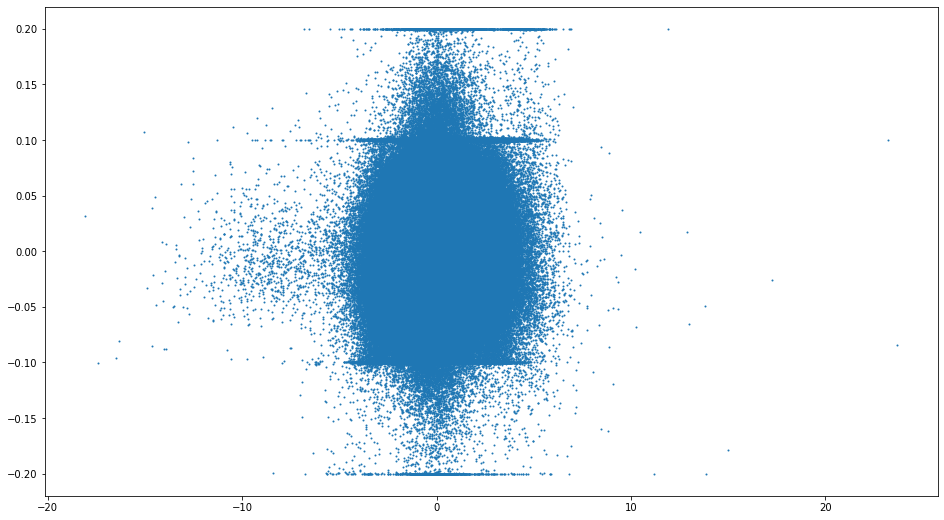

In [389]:
fig = plt.figure(figsize=(16, 9))
plt.scatter(factor_df, period_df, s=1)

In [410]:
# 相关性检验
(
    np.nan_to_num(
        [
            np.corrcoef(i, j)[0][1]
            for i, j in zip(np.nan_to_num(period_df.T), np.nan_to_num(factor_df.T))
        ]
    )
)

/usr/local/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


array([0.03208379, 0.02807961, 0.06713075, ..., 0.05682351, 0.02200534,
       0.16346741])

In [411]:
# 计算每期IC
(
    np.nan_to_num(
        [
            np.corrcoef(i, j)[0][1]
            for i, j in zip(np.nan_to_num(period_df), np.nan_to_num(factor_df))
        ]
    )
)

/usr/local/miniconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


array([ 0.19183068,  0.20441547,  0.02730215, -0.05631447, -0.31498919,
        0.12006814,  0.05625563,  0.04555467, -0.05193592,  0.04866266,
        0.12289824,  0.09032682,  0.27357925, -0.10502848,  0.04410514,
        0.59216446,  0.13043962,  0.11504715,  0.41216798,  0.26887178,
        0.00803664,  0.0217773 , -0.07834115,  0.11540615,  0.14386666,
        0.10258384,  0.23177949,  0.05767402,  0.07440587,  0.08657267,
        0.33910604,  0.36526523, -0.21265784,  0.02646976,  0.06225846,
       -0.40535542,  0.16208337,  0.13398125,  0.15184941,  0.05244243,
        0.32362683, -0.33300254, -0.05675871,  0.15909259,  0.28863122,
        0.06845093,  0.00332293,  0.14688465,  0.10188732, -0.0672485 ,
        0.20461537, -0.15347958,  0.10636955,  0.09421095, -0.01360415,
        0.29321   ,  0.18125134, -0.06718801,  0.15889987, -0.08391608,
       -0.02385595,  0.107841  ,  0.01838953, -0.08505414,  0.20608313,
       -0.21969869,  0.0483942 ,  0.11728681, -0.0706134 ,  0.09

In [391]:
# 显著性检验

In [392]:
# 滚动训练，获取预测值
# todo: 要用多长时间训练呢

y_predict_dict = {}

for i in range(252, len(close.index) - 1):
    date = close.index[i]
    start_date = close.index[i - 252]
    end_date = close.index[i - 1]

    x_test = factor_df.loc[
        (factor_df.index > start_date) & (factor_df.index < end_date)
    ]
    y_test = period_df.loc[
        (period_df.index > start_date) & (period_df.index < end_date)
    ]
    x_predict = [np.nan_to_num(factor_df.loc[date, :])]

    lr_model = LinearRegression()
    lr_model.fit(np.nan_to_num(x_test), np.nan_to_num(y_test))

    y_predict = lr_model.predict(x_predict)
    y_predict_dict[date] = y_predict[0]

In [444]:
x_predict

[array([0.24464696, 0.01199225, 0.18984272, ..., 0.25639563, 0.82393641,
        1.44730927])]

In [445]:
y_predict_dict

{Timestamp('2021-01-15 00:00:00'): array([ 0.00181461, -0.00321371,  0.02068789, ...,  0.        ,
        -0.01548056, -0.01658515]),
 Timestamp('2021-01-18 00:00:00'): array([-0.00898906,  0.00500197,  0.00527183, ...,  0.        ,
        -0.0019004 ,  0.0035041 ]),
 Timestamp('2021-01-19 00:00:00'): array([ 0.01372986,  0.00843935,  0.02391199, ...,  0.        ,
        -0.01138331,  0.0098994 ]),
 Timestamp('2021-01-20 00:00:00'): array([ 0.00802013,  0.00654348,  0.00880607, ..., -0.00497009,
         0.01079076,  0.03035301]),
 Timestamp('2021-01-21 00:00:00'): array([-0.00035282,  0.00569213, -0.00930121, ...,  0.00256052,
         0.01777308,  0.01294863]),
 Timestamp('2021-01-22 00:00:00'): array([ 0.01573216,  0.00378832, -0.01100668, ..., -0.00012599,
         0.00696089,  0.02338715]),
 Timestamp('2021-01-25 00:00:00'): array([-0.00140313, -0.00297938, -0.00820146, ...,  0.00053838,
        -0.00326221, -0.01575752]),
 Timestamp('2021-01-26 00:00:00'): array([-0.00070906, 

In [393]:
y_predict_df = pd.DataFrame(y_predict_dict, index=period_df.columns)
y_predict_df

,2021-01-15,2021-01-18,2021-01-19,2021-01-20,2021-01-21,2021-01-22,2021-01-25,2021-01-26,2021-01-27,2021-01-28,...,2022-05-18,2022-05-19,2022-05-20,2022-05-23,2022-05-24,2022-05-25,2022-05-26,2022-05-27,2022-05-30,2022-05-31
code,,,,,,,,,,,,,,,,,,,,,
000001,0.00181,-0.00899,0.01373,0.00802,-0.00035,0.01573,-0.00140,-0.00071,0.00310,-0.00188,...,192971202.79971,-2414921455.73639,197139267.04459,-29628479.05851,-300257832.61964,-4433871.35674,72664592.14495,-412225142.00940,-346284486.34847,-249990274.35324
000002,-0.00321,0.00500,0.00844,0.00654,0.00569,0.00379,-0.00298,-0.00998,0.00191,0.00140,...,233809094.10187,-2925983720.40844,238859232.71557,-35898661.29546,-363800457.40491,-5372197.67101,88042372.20452,-499463057.80775,-419567587.70383,-302894933.21531
000004,0.02069,0.00527,0.02391,0.00881,-0.00930,-0.01101,-0.00820,0.01430,0.02854,-0.01731,...,472515270.30580,-5913251550.63218,482721321.65254,-72549212.39473,-735220638.30025,-10856914.83863,177928773.32739,-1009387263.62169,-847922929.64792,-612133936.55424
000005,0.00601,-0.00292,0.01373,0.00677,-0.00992,0.00231,-0.01438,-0.00084,-0.00428,0.00565,...,-36849964.07249,461155692.98731,-37645901.58265,5657882.44753,57337520.63049,846696.23999,-13876099.51730,78718904.26778,66126814.06490,47738379.95767
000006,-0.01318,-0.00105,0.01518,-0.00192,-0.00632,0.01162,-0.01436,-0.01296,0.00989,0.01331,...,48601625.39136,-608220845.10507,49651391.85432,-7462213.13845,-75622779.50102,-1116712.51828,18301265.84578,-103822807.03044,-87215028.26878,-62962418.79574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-255639100.33138,3199173448.34939,-261160754.18547,39250404.30450,397767340.84443,5873782.57850,-96262606.48512,546096323.72340,458741269.50895,331175262.94155
688800,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,-14508473.67736,181565040.04895,-14821848.16737,2227606.96962,22574781.93138,333359.02881,-5463262.49743,30993005.64568,26035280.06197,18795432.77906
688819,0.00000,0.00000,0.00000,-0.00497,0.00256,-0.00013,0.00054,0.00592,-0.00502,0.00491,...,16791177.50225,-210131741.87091,17153857.01679,-2578089.66551,-26126606.04704,-385808.50182,6322829.73121,-35869318.64818,-30131564.86585,-21752629.62912


In [430]:
clean_factor_data = meta_data.copy()
clean_factor_data["predict_period"] = y_predict_df.unstack()
clean_factor_data.dropna(inplace=True)
clean_factor_data["factor_rank"] = (
    clean_factor_data["predict_period"]
    .groupby(level=0)
    .apply(lambda x: x.rank(method="first"))
)
clean_factor_data

period   factor  predict_period  factor_rank
trading_date code                                                 
2021-01-15   000001  0.08095  0.04115         0.00181   1593.00000
             000002  0.04374 -0.00133        -0.00321    965.00000
             000004  0.06441  0.04370         0.02069   3743.00000
             000005  0.00885  0.02727         0.00601   2266.00000
             000006  0.00945 -0.00564        -0.01318    290.00000
...                      ...      ...             ...          ...
2022-05-26   688799  0.00069 -0.00684 -96262606.48512    426.00000
             688800 -0.03125  0.01033  -5463262.49743   2231.00000
             688819  0.01069 -0.01513   6322829.73121   2735.00000
             688981 -0.00684  0.00094   2401790.91271   2571.00000
             689009  0.01226 -0.00794 -29104477.31979   1460.00000

[1449629 rows x 4 columns]

In [441]:
# 对因子进行分组
backtest_cs = BacktestCS()
clean_factor_data = backtest_cs.cal_factor_quantile(
    clean_factor_data=clean_factor_data, group_num=10
)
clean_factor_data.head()

period   factor  predict_period  factor_rank  \
trading_date code                                                   
2021-01-15   000001 0.08095  0.04115         0.00181   1593.00000   
             000002 0.04374 -0.00133        -0.00321    965.00000   
             000004 0.06441  0.04370         0.02069   3743.00000   
             000005 0.00885  0.02727         0.00601   2266.00000   
             000006 0.00945 -0.00564        -0.01318    290.00000   

                     factor_quantile  
trading_date code                     
2021-01-15   000001                4  
             000002                3  
             000004               10  
             000005                6  
             000006                1

In [440]:
# 获取做多的组合 和做空的组合
long_portfolio_data, short_portfolio_data = backtest_cs.cal_hold_portfolio(
    clean_factor_data=clean_factor_data, hold_num=1
)

In [436]:
# 计算回测指标
ret_df, sharpe_ratio, annual_return, max_down = backtest_cs.describer_01(
    long_portfolio_data, short_portfolio_data
)

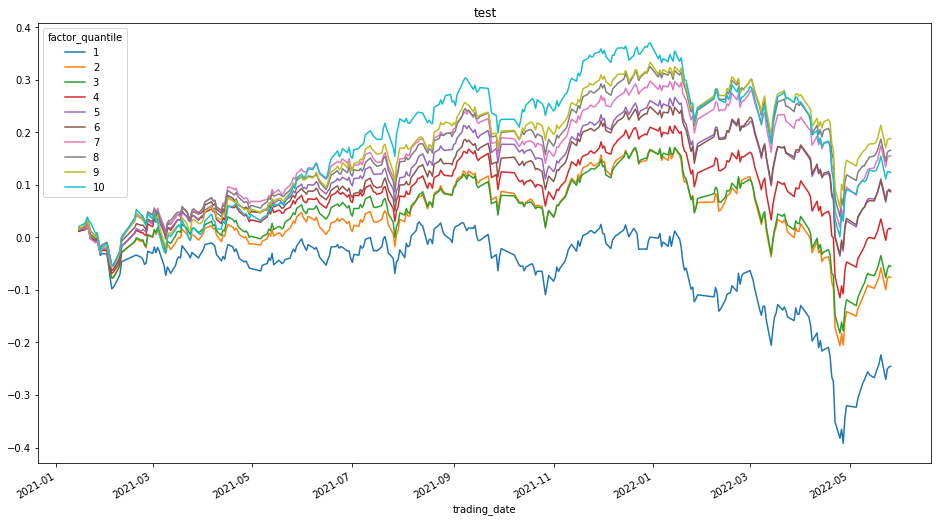

In [439]:
# 分组画图
PlotCS.plot_group_cumsum_pnl(clean_factor_data)

<AxesSubplot:xlabel='trading_date'>

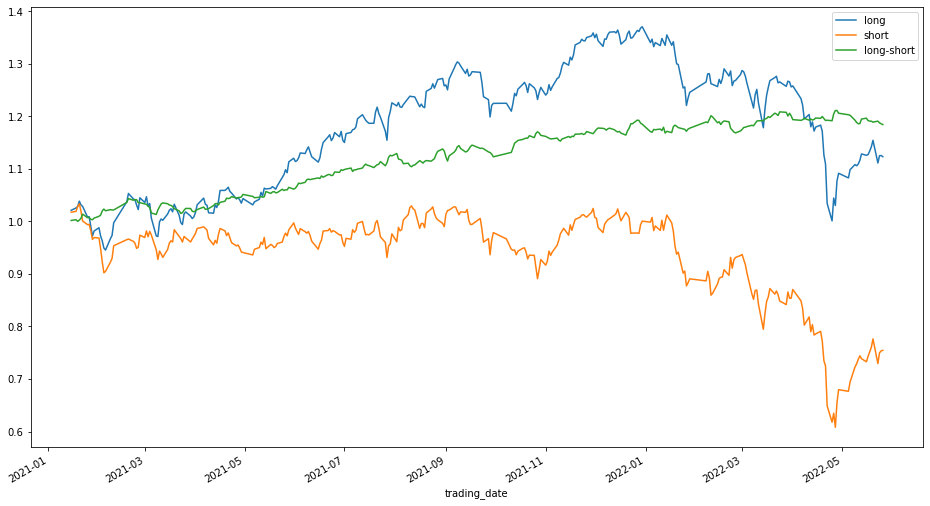

In [438]:
# 画出多空收益
ret_df.plot(figsize=(16, 9))